Потренируемся самостоятельно писать многослойный перцептрон для работы с текстами.

Возьмем для этого датасет про юридические тексты. В этом датасете есть описания дел, а в качестве цп - то, что с делами произошло.

In [1]:
!wget https://raw.githubusercontent.com/rsuh-python/mag2022/main/CL/term02/06-Embeddings/legal_text_classification.csv

--2025-01-08 18:12:52--  https://raw.githubusercontent.com/rsuh-python/mag2022/main/CL/term02/06-Embeddings/legal_text_classification.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68202412 (65M) [text/plain]
Saving to: ‘legal_text_classification.csv’

legal_text_classifi 100%[===================>]  65.04M   201MB/s    in 0.3s    

2025-01-08 18:12:55 (201 MB/s) - ‘legal_text_classification.csv’ saved [68202412/68202412]



Для начала напишем бейзлайн - логистическую регрессию. Возьмем в качестве признаков только текст - описание самого дела (case_text). Целевую переменную, очевидно, нужно превратить в чиселки (OHE).

- проверьте данные на пропуски
- проверьте баланс классов - это очень важно!
- используйте TF-IDF
- не забудьте использовать LabelEncoder
- логистической регрессии может понадобиться выставить solver='liblinear'
- если не помните, как работать с несбалансированными датасетами, просмотрите наши конспекты - точно где-то было (на худой конец документация к логрегу)

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv('legal_text_classification.csv')
data.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24985 non-null  object
 1   case_outcome  24985 non-null  object
 2   case_title    24985 non-null  object
 3   case_text     24809 non-null  object
dtypes: object(4)
memory usage: 780.9+ KB


In [4]:
data.dropna(inplace=True)

In [ ]:
data.case_outcome.unique()

array(['cited', 'applied', 'followed', 'referred to', 'related',
       'considered', 'discussed', 'distinguished', 'affirmed', 'approved'],
      dtype=object)

In [ ]:
data.case_outcome.value_counts()

,count
case_outcome,
cited,12110
referred to,4363
applied,2438
followed,2252
considered,1699
discussed,1018
distinguished,603
related,112
approved,108


Выборка несбалансирована

In [5]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X = tfidf.fit_transform(data['case_text'])

In [6]:
le = LabelEncoder()
y = le.fit_transform(data['case_outcome'])
y

array([3, 3, 3, ..., 3, 6, 6])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [ ]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

               precision    recall  f1-score   support

     affirmed       0.32      0.86      0.46        21
      applied       0.30      0.26      0.28       488
     approved       0.15      0.33      0.21        21
        cited       0.68      0.69      0.69      2422
   considered       0.28      0.31      0.29       340
    discussed       0.23      0.41      0.29       204
distinguished       0.24      0.47      0.32       121
     followed       0.36      0.29      0.32       450
  referred to       0.56      0.39      0.46       873
      related       0.19      0.50      0.27        22

     accuracy                           0.51      4962
    macro avg       0.33      0.45      0.36      4962
 weighted avg       0.53      0.51      0.52      4962



Если все сделали как я, должна получиться средняя f-score в районе 0.5.

Теперь давайте попробуем написать нейронную сетку по аналогии с тетрадкой про твиттер из прошлого семинара.

In [7]:
import numpy as np
import random
from string import punctuation
from collections import Counter
from sklearn.utils import shuffle, class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

import matplotlib.pyplot as plt

In [8]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

class_weight - очень полезная для нас штука. Можно вычислить веса классов автоматически с ее помощью:

In [9]:
# первый аргумент - какие веса высчитывать, второй - какие у нас классы, третий - какие их частоты
yweights = class_weight.compute_class_weight('balanced', classes=np.unique(data.case_outcome), y=data.case_outcome)
# превращаем их в torch.tensor
yweights = torch.tensor(yweights, dtype=torch.float32)

Заметьте, что возвращает оно np.array.

In [10]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

Нужно написать:

- функцию для предобработки текста, которая получает сырой текст и возвращает список токенов
- создать словарь word2id
- и обратный ему id2word

In [11]:
import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def preprocess(text):
    """убираем ссылки, приводим к нижнему регистру, удаляем стоп-слова, пунктуацию и короткие токены"""
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [t for t in tokens if len(t) > 2]

    return tokens

In [13]:
vocab = Counter()

for text in data['case_text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 61743


In [14]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 37524


In [15]:
word2id = {'PAD': 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [16]:
id2word = {i: word for word, i in word2id.items()}

Лучше это все, конечно, запускать в колабе... не забудьте там выбрать T4 GPU в рантайме

In [17]:
train_df, val_df = train_test_split(data, test_size=0.2, stratify=y, random_state=42)

Нужно написать класс для нашего датасета (можно беспощадно копипастить из тетрадки про твиттер)

In [18]:
class LegalDataset(Dataset):
    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['case_text'].values
        self.targets = dataset['case_outcome'].values
        self.word2id = word2id
        self.length = len(self.dataset)
        self.device = DEVICE
        self.le = LabelEncoder()
        self.targets = self.le.fit_transform(self.targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        text = self.dataset[index]
        tokens = preprocess(text)
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        return ids, self.targets[index]

    def collate_fn(self, batch):
        texts, labels = list(zip(*batch))
        padded_texts = pad_sequence(texts, batch_first=True).to(self.device)
        labels = torch.LongTensor(labels).to(self.device)
        return padded_texts, labels


In [19]:
BATCH_SIZE = 256

In [35]:
train_dataset = LegalDataset(train_df, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=BATCH_SIZE)

In [36]:
val_dataset = LegalDataset(val_df, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler, batch_size=BATCH_SIZE)

Ну и наконец напишем архитектуру. Модель при инициализации должна принимать размер словаря и эмбеддинга. У нас в датасете 10 классов, поэтому, в отличие от тетрадки про твиттер, нужно использовать Softmax и возвращать вероятности классов. В качестве лосса подойдет кросс-энтропия (я ее уже за вас вписала вместе с весами классов).

In [22]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.emb2h = nn.Linear(embedding_dim, 32)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.h2out = nn.Linear(32, 10) # 10 классов

    def forward(self, text):
        embedded = self.embedding(text)
        mean_emb = torch.mean(embedded, dim=1)
        hidden = self.emb2h(mean_emb)
        hidden = self.act1(hidden)
        hidden = self.dropout(hidden)
        out = self.h2out(hidden)
        return out

In [23]:
batch, y = next(iter(train_iterator))

In [24]:
#пропустим через модель наш первый батч, чтобы проверить, что все работает
model = MLP(len(id2word), 5).to(DEVICE)
output = torch.argmax(model(batch), dim=1) # argmax из вероятностей сделает классы
output

tensor([1, 1, 1, 1, 1, 9, 1, 4, 4, 9, 1, 9, 1, 4, 9, 9, 9, 1, 9, 1, 1, 9, 1, 9,
        1, 1, 1, 1, 1, 4, 4, 9, 9, 9, 9, 1, 1, 1, 4, 1, 1, 1, 1, 1, 9, 1, 1, 1,
        9, 9, 1, 4, 1, 1, 1, 1, 9, 1, 1, 9, 9, 4, 9, 1, 1, 9, 1, 9, 1, 9, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 9, 9, 9, 1, 1, 1, 1, 4, 1, 4, 4, 1, 1,
        9, 1, 1, 1, 1, 1, 1, 9, 1, 4, 9, 1, 1, 9, 1, 1, 4, 1, 9, 9, 1, 1, 9, 1,
        1, 1, 9, 4, 1, 4, 9, 1, 1, 1, 9, 1, 1, 9, 1, 1, 1, 1, 1, 1, 9, 9, 9, 4,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 4, 1, 4, 9, 1, 1, 1, 1, 1, 1, 9,
        9, 1, 1, 9, 9, 1, 1, 9, 1, 1, 9, 1, 4, 9, 1, 1, 1, 3, 1, 8, 1, 1, 1, 9,
        1, 9, 1, 1, 1, 4, 1, 1, 9, 9, 4, 1, 9, 9, 9, 9, 9, 9, 1, 1, 4, 1, 1, 9,
        1, 4, 1, 1, 8, 9, 1, 9, 9, 1, 1, 1, 1, 1, 9, 9, 1, 1, 1, 4, 1, 1, 1, 1,
        1, 9, 1, 1, 3, 1, 1, 9, 1, 1, 1, 1, 9, 1, 4, 1], device='cuda:0')

Теперь нужно написать трейнлуп (лучше скопипастить откуда-нибудь), инициализировать нашу модель и запустить)

In [25]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss/len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_true = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):
            outputs = model(texts)
            loss = criterion(outputs, ys)
            epoch_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(ys.cpu().numpy())
    # вычислим F1 (weighted)
    f1 = f1_score(all_true, all_preds, average='weighted')
    return epoch_loss/len(iterator), f1

In [27]:
def run_experiment(model, train_iterator, val_iterator, optimizer, criterion, num_epochs=50, patience=5, scheduler=None):
    train_losses = []
    val_losses = []
    val_f1s = []

    best_loss = np.inf
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        tr_loss = train(model, train_iterator, optimizer, criterion)
        val_loss, val_f1 = evaluate(model, val_iterator, criterion)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        val_f1s.append(val_f1)

        if scheduler is not None:
            scheduler.step()
            if epoch % 5 == 0:
                print(f'Epoch {epoch}, lr: {scheduler.get_last_lr()[0]}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epoch % 5 == 0:
            print(f'Epoch {epoch}, train_loss={tr_loss:.4f}, val_loss={val_loss:.4f}, val_f1={val_f1:.4f}')

        # если несколько эпох подряд (patience) нет улучшения
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    final_epoch = len(train_losses) - 1
    print(f'Final epoch: {final_epoch}, train_loss={train_losses[-1]:.4f}, val_loss={val_losses[-1]:.4f}, val_f1={val_f1s[-1]:.4f}')
    print(f'Best val_loss={best_loss:.4f}')

    # загружаем лучшие веса
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # графики
    plt.figure(figsize=(10,4))
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, label='Val loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(val_f1s, label='Val F1')
    plt.title('Val F1')
    plt.legend()
    plt.show()

In [ ]:
model = MLP(len(word2id), 5).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))

Epoch 0, train_loss=2.3330, val_loss=2.3053, val_f1=0.0151
Epoch 5, train_loss=2.3042, val_loss=2.3004, val_f1=0.2756
Epoch 10, train_loss=2.3017, val_loss=2.2979, val_f1=0.1509
Epoch 15, train_loss=2.2972, val_loss=2.2947, val_f1=0.3166
Epoch 20, train_loss=2.2900, val_loss=2.2908, val_f1=0.0661
Epoch 25, train_loss=2.2876, val_loss=2.2874, val_f1=0.3261
Epoch 30, train_loss=2.2775, val_loss=2.2787, val_f1=0.0635
Epoch 35, train_loss=2.2593, val_loss=2.2669, val_f1=0.3200
Epoch 40, train_loss=2.2341, val_loss=2.2491, val_f1=0.0741
Epoch 45, train_loss=2.2067, val_loss=2.2250, val_f1=0.2965
Epoch 50, train_loss=2.1742, val_loss=2.1962, val_f1=0.2219
Epoch 55, train_loss=2.1292, val_loss=2.1667, val_f1=0.0672
Epoch 60, train_loss=2.0896, val_loss=2.1363, val_f1=0.0680
Epoch 65, train_loss=2.0678, val_loss=2.1346, val_f1=0.0700
Epoch 70, train_loss=2.0494, val_loss=2.0959, val_f1=0.1406
Epoch 75, train_loss=2.0139, val_loss=2.0865, val_f1=0.0648
Epoch 80, train_loss=2.0025, val_loss=2.08

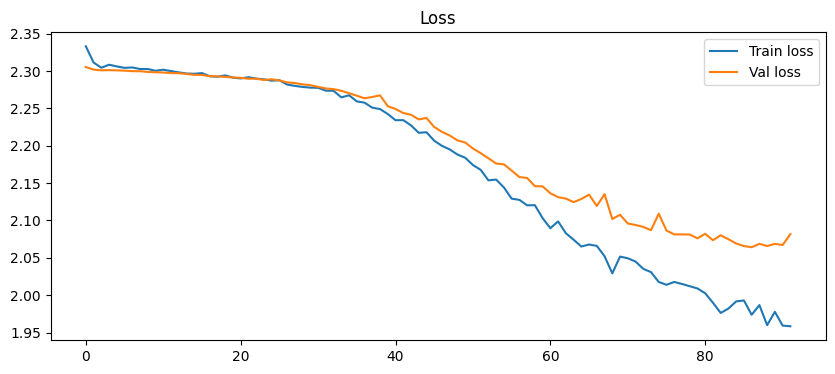

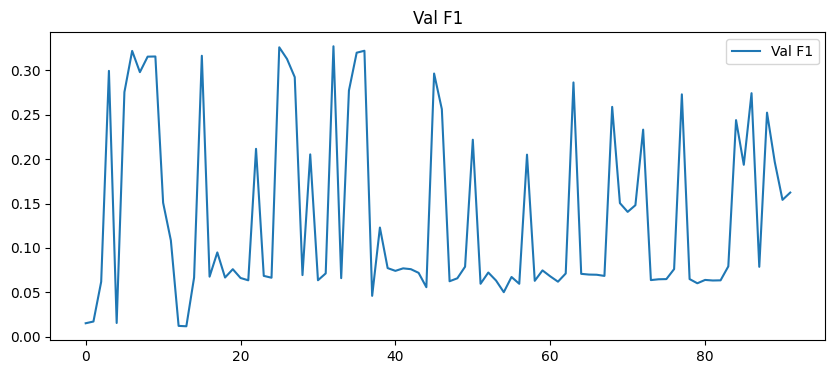

In [ ]:
run_experiment(model, train_iterator, val_iterator, optimizer, criterion, num_epochs=100, patience=5)

пока результаты не очень.  
возможные причины:
* недостаточно сложная архитектура
* данные все-таки очень несбалансированы

Скорее всего, вам понадобится учиться очень много эпох, чтобы предсказывать что-нибудь стоящее (эпох 100...), и, вероятнее всего, придется играться с архитектурой, чтобы получить приличное качество. На семинаре на эксперименты времени нет, поэтому добаловаться можно дома - и заодно попробовать подключить эмбеддинги w2v, например.

In [ ]:
set_random_seed(42)

In [ ]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.fc1 = nn.Linear(embedding_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.4)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.3)

        self.out = nn.Linear(32, 10)

    def forward(self, text):
        embedded = self.embedding(text)

        mean_emb = torch.mean(embedded, dim=1)

        x = self.fc1(mean_emb)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.dropout3(x)

        outputs = self.out(x)
        return outputs

In [ ]:
model = MLP(len(word2id), embedding_dim=50).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

Epoch 0, lr: 0.0009938441702975688
Epoch 0, train_loss=2.3935, val_loss=2.3010, val_f1=0.1530
Epoch 5, lr: 0.0007938926261462366
Epoch 5, train_loss=2.0667, val_loss=2.1100, val_f1=0.1822
Epoch 10, lr: 0.0004217827674798847
Epoch 10, train_loss=1.8580, val_loss=2.0258, val_f1=0.1957
Epoch 15, lr: 9.549150281252631e-05
Epoch 15, train_loss=1.7425, val_loss=2.0088, val_f1=0.1945
Epoch 20, lr: 6.155829702431115e-06
Epoch 20, train_loss=1.7434, val_loss=2.0107, val_f1=0.2006
Epoch 25, lr: 0.0002061073738537634
Epoch 25, train_loss=1.7075, val_loss=2.0088, val_f1=0.2199
Epoch 30, lr: 0.0005782172325201154
Epoch 30, train_loss=1.6693, val_loss=2.0245, val_f1=0.1936
Epoch 35, lr: 0.0009045084971874734
Epoch 35, train_loss=1.5697, val_loss=2.1089, val_f1=0.1252
Early stopping at epoch 37
Final epoch: 37, train_loss=1.5257, val_loss=2.1059, val_f1=0.1384
Best val_loss=2.0036


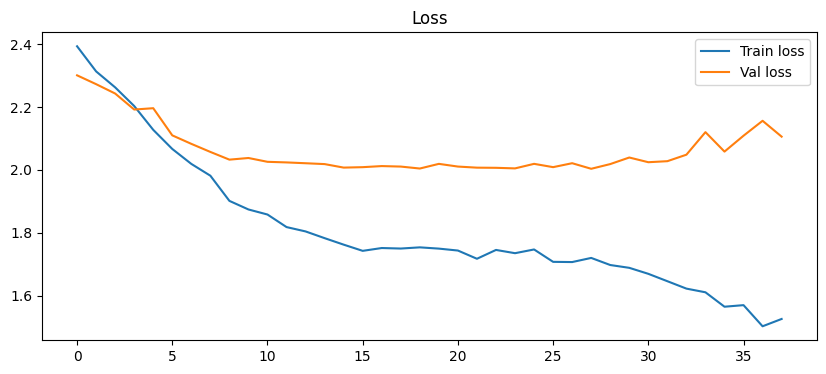

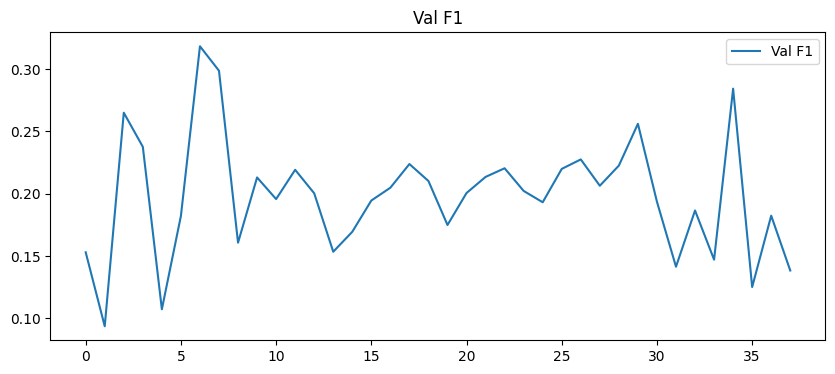

In [ ]:
run_experiment(model, train_iterator, val_iterator, optimizer, criterion, num_epochs=100, patience=10, scheduler=scheduler)

Я изменил архитектуру модели (добавил больше скрытых слоев, использовал AdamW и scheduler), но началось переобучение

In [ ]:
set_random_seed(42)

In [ ]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim=50):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.fc1 = nn.Linear(embedding_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.7)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3)

        self.out = nn.Linear(64, 10)

    def forward(self, text):
        embedded = self.embedding(text)
        mean_emb = torch.mean(embedded, dim=1)

        x = self.fc1(mean_emb)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        outputs = self.out(x)
        return outputs


In [ ]:
model = MLP(len(word2id), embedding_dim=50).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

Epoch 0, lr: 0.0004969220851487844
Epoch 0, train_loss=2.3927, val_loss=2.3043, val_f1=0.0413
Epoch 5, lr: 0.0003969463130731183
Epoch 5, train_loss=2.2086, val_loss=2.2193, val_f1=0.1729
Epoch 10, lr: 0.00021089138373994235
Epoch 10, train_loss=2.0961, val_loss=2.1314, val_f1=0.1452
Epoch 15, lr: 4.774575140626316e-05
Epoch 15, train_loss=2.0364, val_loss=2.1195, val_f1=0.1369
Epoch 20, lr: 3.0779148512155576e-06
Epoch 20, train_loss=2.0155, val_loss=2.1092, val_f1=0.1412
Epoch 25, lr: 0.0001030536869268817
Epoch 25, train_loss=2.0082, val_loss=2.0938, val_f1=0.1509
Epoch 30, lr: 0.0002891086162600577
Epoch 30, train_loss=1.9758, val_loss=2.0963, val_f1=0.1433
Epoch 35, lr: 0.0004522542485937367
Epoch 35, train_loss=1.8718, val_loss=2.0408, val_f1=0.1621
Epoch 40, lr: 0.0004969220851487843
Epoch 40, train_loss=1.7892, val_loss=2.0220, val_f1=0.1737
Epoch 45, lr: 0.00039694631307311823
Epoch 45, train_loss=1.6774, val_loss=2.0416, val_f1=0.2147
Epoch 50, lr: 0.00021089138373994246
Epoc

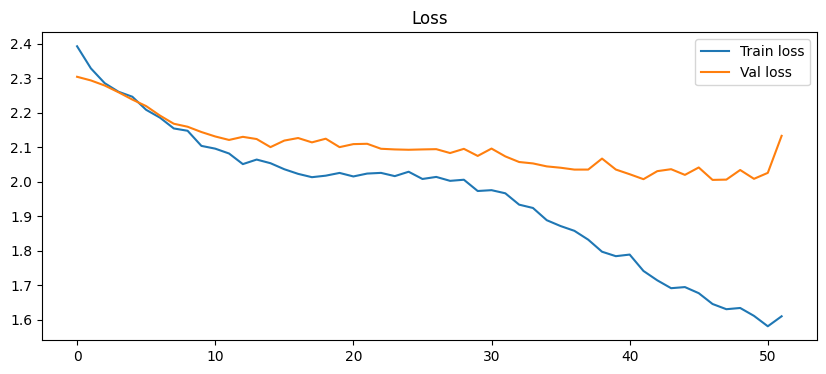

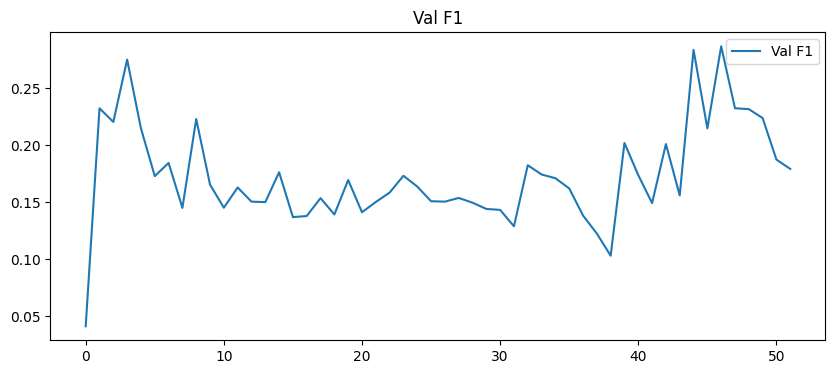

In [ ]:
run_experiment(model, train_iterator, val_iterator, optimizer, criterion, num_epochs=100, patience=5, scheduler=scheduler)

Попробуем добавить w2v

In [28]:
import gensim

In [29]:
texts = [preprocess(text) for text in data['case_text'].values]

In [30]:
w2v_model = gensim.models.Word2Vec(
    sentences=texts,
    vector_size=100,
    window=5,
    min_count=1,
)

In [31]:
embedding_dim = 100
weights = np.zeros((len(word2id), embedding_dim))

In [32]:
oov_count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue
    try:
        weights[i] = w2v_model.wv[word]
    except KeyError:
        oov_count += 1
        # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0, 0.1, embedding_dim)

In [33]:
print(f'Всего слов в словаре: {len(word2id)}')
print(f'Из них OOV: {oov_count}')

Всего слов в словаре: 37525
Из них OOV: 0


In [35]:
set_random_seed(42)

In [ ]:
class MLP_w2v(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(weights, dtype=torch.float32),
            freeze=True,
            padding_idx=0
        )

        self.fc1 = nn.Linear(embedding_dim, 128)
        self.act1 = nn.LeakyReLU() # LeakyReLU вместо ReLU
        self.dropout1 = nn.Dropout(p=0.4)

        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(p=0.3)

        self.out = nn.Linear(64, 10)

    def forward(self, text):
        embedded = self.embedding(text)
        mean_emb = torch.mean(embedded, dim=1)

        x = self.fc1(mean_emb)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        outputs = self.out(x)
        return outputs

Epoch 0, train_loss=2.3027, val_loss=2.2966, val_f1=0.0036
Epoch 5, train_loss=2.0941, val_loss=2.0646, val_f1=0.1570
Epoch 10, train_loss=1.9831, val_loss=1.9853, val_f1=0.2823
Epoch 15, train_loss=1.9389, val_loss=1.9513, val_f1=0.2498
Epoch 20, train_loss=1.9186, val_loss=1.9325, val_f1=0.2725
Epoch 25, train_loss=1.8773, val_loss=1.9347, val_f1=0.2610
Epoch 30, train_loss=1.8731, val_loss=1.9092, val_f1=0.2667
Epoch 35, train_loss=1.8506, val_loss=1.9049, val_f1=0.2536
Early stopping at epoch 38
Final epoch: 38, train_loss=1.8396, val_loss=1.9221, val_f1=0.2640
Best val_loss=1.9017


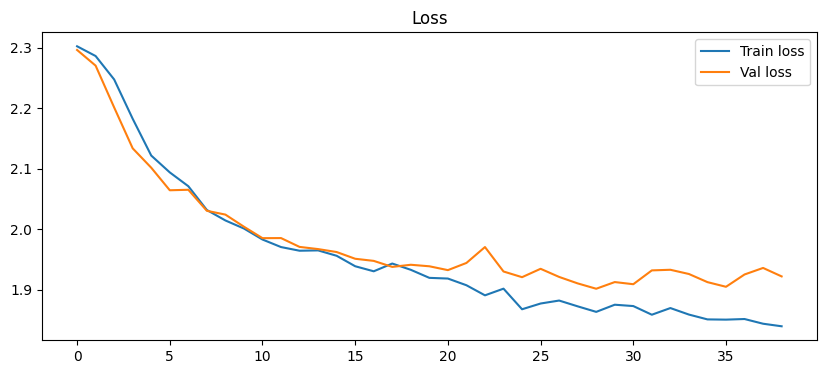

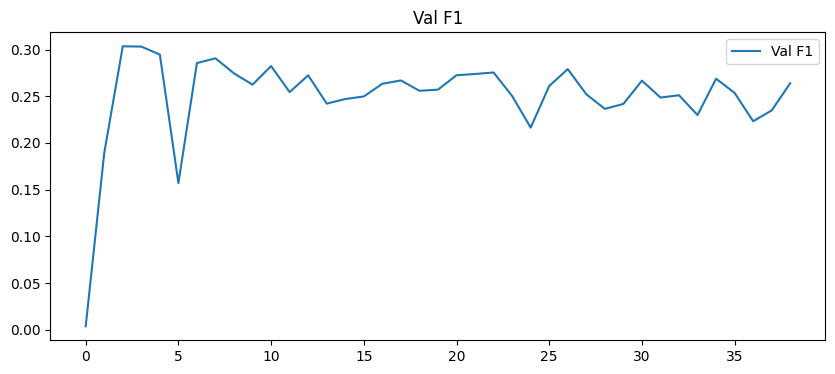

In [ ]:
model = MLP_w2v(len(word2id), embedding_dim=embedding_dim).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))

run_experiment(model, train_iterator, val_iterator, optimizer, criterion, num_epochs=100, patience=10)

есть небольшой прогресс, но результаты все еще далеки от идеала...

torch.mean учитывает паддинг при вычислении среднего значения, поэтому добавил маску для игнорирования нулевых эмбеддингов
(идея взята отсюда:
https://stackoverflow.com/questions/76015844/how-to-efficiently-mean-pool-bert-embeddings-while-excluding-padding)

In [34]:
set_random_seed(42)

In [37]:
class MLP_w2v(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(weights, dtype=torch.float32),
            freeze=True,
            padding_idx=0
        )

        self.fc1 = nn.Linear(embedding_dim, 128)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(p=0.4)

        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(p=0.3)

        self.out = nn.Linear(64, 10)

    def forward(self, text):
        embedded = self.embedding(text)

        mean_emb = torch.sum(embedded, dim=1) / torch.where(text != 0, 1, 0).sum(dim=1, keepdim=True)

        x = self.fc1(mean_emb)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        outputs = self.out(x)
        return outputs

Epoch 0, train_loss=2.2796, val_loss=2.2341, val_f1=0.1417
Epoch 5, train_loss=1.8998, val_loss=1.9241, val_f1=0.2257
Epoch 10, train_loss=1.8373, val_loss=1.8974, val_f1=0.2206
Epoch 15, train_loss=1.7895, val_loss=1.8765, val_f1=0.2293
Epoch 20, train_loss=1.7497, val_loss=1.8828, val_f1=0.2229
Epoch 25, train_loss=1.7154, val_loss=1.9090, val_f1=0.2055
Early stopping at epoch 25
Final epoch: 25, train_loss=1.7154, val_loss=1.9090, val_f1=0.2055
Best val_loss=1.8765


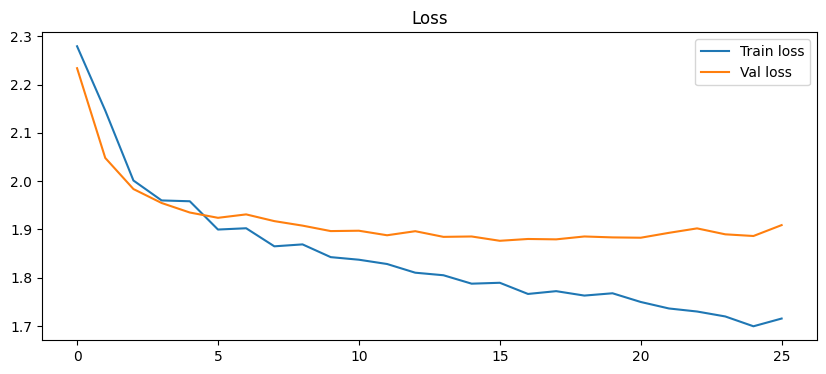

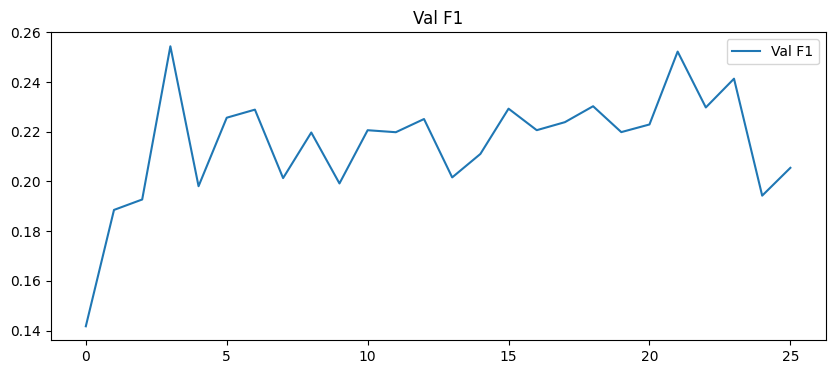

In [38]:
model = MLP_w2v(len(word2id), embedding_dim=embedding_dim).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))

run_experiment(model, train_iterator, val_iterator, optimizer, criterion, num_epochs=100, patience=10)

val_loss уменьшился  
при этом f1 тоже снизился...

In [187]:
set_random_seed(42)

In [190]:
class MLP_w2v(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(weights, dtype=torch.float32),
            freeze=True,
            padding_idx=0
        )

        self.fc1 = nn.Linear(embedding_dim, 128)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(p=0.3) # уменьшил

        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(p=0.1)

        self.out = nn.Linear(64, 10)

    def forward(self, text):
        embedded = self.embedding(text)

        mean_emb = torch.sum(embedded, dim=1) / torch.where(text != 0, 1, 0).sum(dim=1, keepdim=True)

        x = self.fc1(mean_emb)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        outputs = self.out(x)
        return outputs

Epoch 0, lr: 0.0009000000000000001
Epoch 0, train_loss=2.2021, val_loss=2.0306, val_f1=0.2071
Epoch 5, lr: 0.000531441
Epoch 5, train_loss=1.8214, val_loss=1.8767, val_f1=0.2319
Epoch 10, lr: 0.00031381059609000004
Epoch 10, train_loss=1.7586, val_loss=1.8601, val_f1=0.2260
Epoch 15, lr: 0.00018530201888518417
Epoch 15, train_loss=1.7147, val_loss=1.8484, val_f1=0.2270
Epoch 20, lr: 0.00010941898913151243
Epoch 20, train_loss=1.7021, val_loss=1.8487, val_f1=0.2308
Epoch 25, lr: 6.461081889226677e-05
Epoch 25, train_loss=1.6938, val_loss=1.8482, val_f1=0.2210
Early stopping at epoch 28
Final epoch: 28, train_loss=1.6759, val_loss=1.8475, val_f1=0.2255
Best val_loss=1.8453


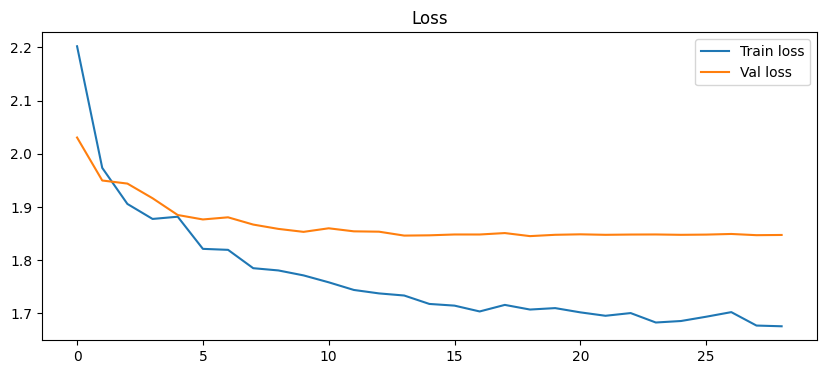

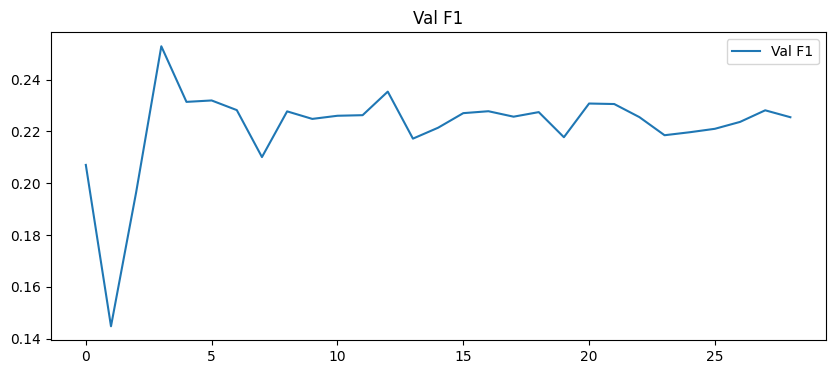

In [191]:
model = MLP_w2v(len(word2id), embedding_dim=embedding_dim).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # здесь лучший результат был с ExponentialLR

run_experiment(model, train_iterator, val_iterator, optimizer, criterion, num_epochs=100, patience=10, scheduler=scheduler)

In [34]:
set_random_seed(42)

In [37]:
class MLP_w2v(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(weights, dtype=torch.float32),
            freeze=True,
            padding_idx=0
        )

        self.fc1 = nn.Linear(embedding_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.act3 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(p=0.3)

        self.out = nn.Linear(64, 10)

    def forward(self, text):
        embedded = self.embedding(text)

        mean_emb = torch.sum(embedded, dim=1) / torch.where(text != 0, 1, 0).sum(dim=1, keepdim=True)

        x = self.fc1(mean_emb)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.dropout3(x)

        outputs = self.out(x)
        return outputs

In [38]:
model = MLP_w2v(len(word2id), embedding_dim=embedding_dim).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=yweights.to(DEVICE))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

Epoch 0, lr: 0.0004980286753286195
Epoch 0, train_loss=2.2753, val_loss=2.1146, val_f1=0.2084
Epoch 5, lr: 0.00043224215685535287
Epoch 5, train_loss=1.9399, val_loss=1.9417, val_f1=0.1742
Epoch 10, lr: 0.0002968453286464312
Epoch 10, train_loss=1.8178, val_loss=1.9011, val_f1=0.1722
Epoch 15, lr: 0.00014355517710873183
Epoch 15, train_loss=1.7793, val_loss=1.8773, val_f1=0.1640
Epoch 20, lr: 3.092332998903411e-05
Epoch 20, train_loss=1.7348, val_loss=1.8679, val_f1=0.1654
Epoch 25, lr: 1.971324671380531e-06
Epoch 25, train_loss=1.7522, val_loss=1.8682, val_f1=0.1650
Epoch 30, lr: 6.775784314464706e-05
Epoch 30, train_loss=1.7595, val_loss=1.8661, val_f1=0.1642
Epoch 35, lr: 0.0002031546713535689
Epoch 35, train_loss=1.7434, val_loss=1.8641, val_f1=0.1643
Epoch 40, lr: 0.00035644482289126796
Epoch 40, train_loss=1.6887, val_loss=1.8595, val_f1=0.1725
Epoch 45, lr: 0.0004690766700109658
Epoch 45, train_loss=1.6978, val_loss=1.8438, val_f1=0.1753
Epoch 50, lr: 0.0004980286753286195
Epoch

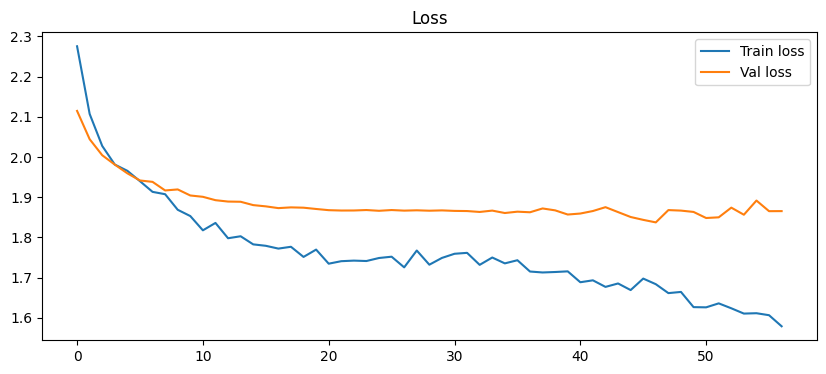

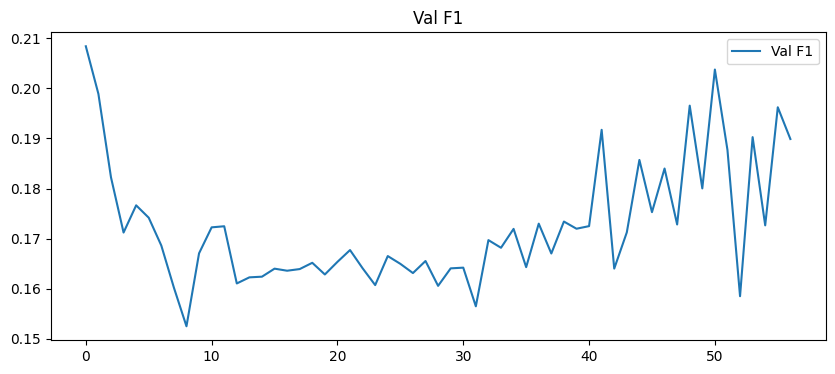

In [246]:
run_experiment(model, train_iterator, val_iterator, optimizer, criterion, num_epochs=100, patience=10, scheduler=scheduler)

здесь лучший val_loss (1.8375) среди всех проведенных экспериментов  

лучший val_f1 был 0.2640  
в целом, результаты слабые...
